In [16]:
import pandas as pd
df = pd.read_csv("../data/data_for_modelling.csv")

In [17]:
df_sampled = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_sampled

,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days_intake,intake_month_num,intake_weekday_num,intake_hour,intactness,sex
0,1,Stray,Normal,Dog,Pug/Beagle,Tan/White,Adoption,0,180,6,0,13,intact,male
1,1,Stray,Normal,Cat,Domestic Shorthair Mix,Black/White,Adoption,0,60,10,3,12,intact,male
2,1,Stray,Sick,Cat,Domestic Shorthair,Flame Point,Adoption,1,60,7,4,12,intact,female
3,2,Owner Surrender,Normal,Dog,Australian Cattle Dog Mix,White/Brown,Transfer,1,2190,4,5,12,not_intact,female
4,1,Stray,Normal,Dog,Labrador Retriever,Black/White,Adoption,1,150,5,2,11,intact,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13516,1,Stray,Normal,Dog,Miniature Pinscher/Pug,Tricolor,Adoption,1,365,7,0,13,intact,female
13517,1,Stray,Normal,Cat,Domestic Shorthair Mix,Tortie,Transfer,1,30,6,1,10,intact,female
13518,1,Stray,Normal,Cat,Domestic Shorthair,Black,Adoption,1,30,7,1,16,not_intact,female
13519,1,Owner Surrender,Normal,Cat,Himalayan Mix,Tortie Point/White,Adoption,1,3650,2,6,10,not_intact,female


In [18]:
df_sampled.columns
print(df_sampled['outcome_type'].value_counts())

outcome_type
Adoption           6418
Transfer           4521
Return to Owner    1972
Euthanasia          452
Died                130
Other                28
Name: count, dtype: int64


In [19]:
data_for_modelling = df_sampled

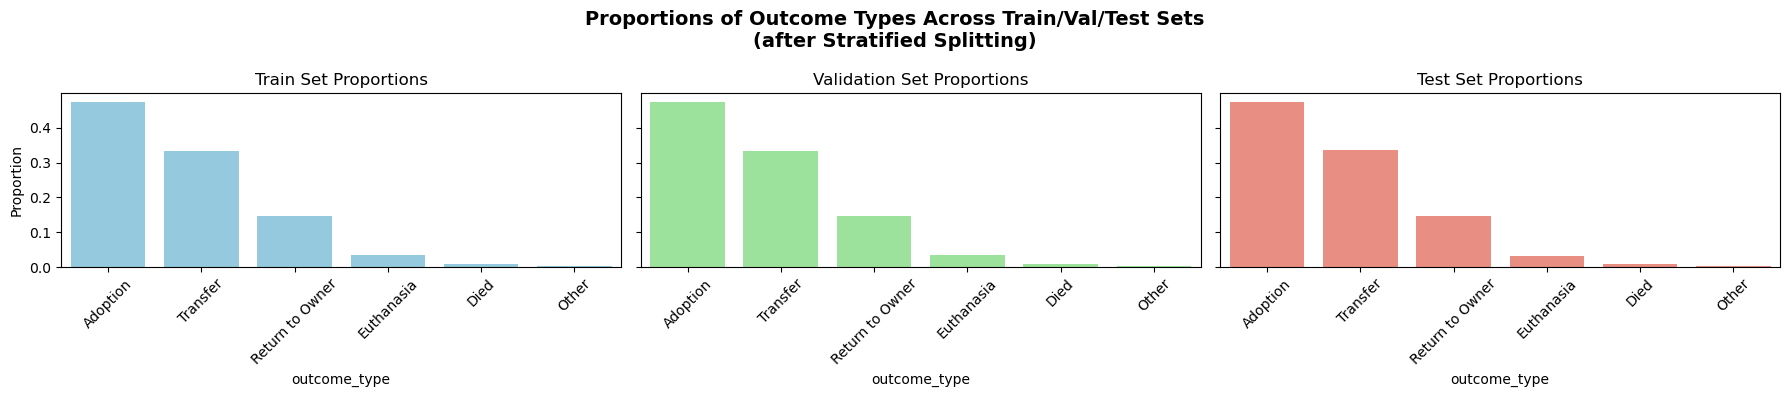

In [20]:
# Ignore this cell
import os
import matplotlib.pyplot as plt
import seaborn as sns

def plot_stratified_props(y_train, y_val, y_test, save_path="../figures/outcome_type_stratified_proportions.png"):
    # Make sure directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    class_order = y.value_counts().index

    train_props = y_train.value_counts(normalize=True).reindex(class_order).fillna(0)
    val_props   = y_val.value_counts(normalize=True).reindex(class_order).fillna(0)
    test_props  = y_test.value_counts(normalize=True).reindex(class_order).fillna(0)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    fig.suptitle(
        "Proportions of Outcome Types Across Train/Val/Test Sets\n(after Stratified Splitting)",
        fontsize=14, fontweight="bold"
    )

    sns.barplot(x=train_props.index, y=train_props.values, ax=axes[0], color="skyblue")
    axes[0].set_title("Train Set Proportions")
    axes[0].set_ylabel("Proportion")
    axes[0].set_xlabel("outcome_type")
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(x=val_props.index, y=val_props.values, ax=axes[1], color="lightgreen")
    axes[1].set_title("Validation Set Proportions")
    axes[1].set_xlabel("outcome_type")
    axes[1].tick_params(axis='x', rotation=45)

    sns.barplot(x=test_props.index, y=test_props.values, ax=axes[2], color="salmon")
    axes[2].set_title("Test Set Proportions")
    axes[2].set_xlabel("outcome_type")
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()

    # ---- save then show ----
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# call as before
plot_stratified_props(y_train, y_val, y_test)


In [5]:
# Training the best model again (best avg macro F2 score)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import shap
import pickle
from datetime import datetime

print("="*80)
print("FINAL MODEL TRAINING AND EVALUATION")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Best hyperparameters found from cross-validation
BEST_REG_ALPHA = 0.0
BEST_REG_LAMBDA = 0.0
BEST_MAX_DEPTH = 3

# Other hyperparameters (from original training)
N_ESTIMATORS = 10000
EARLY_STOPPING_ROUNDS = 50
LEARNING_RATE = 0.03
COLSAMPLE_BYTREE = 0.9
SUBSAMPLE = 0.66

# Random state for final model
FINAL_RANDOM_STATE = 42

# Train/val/test split (matching CV approach)
TRAIN_SIZE = 0.6   # 60% train
VAL_SIZE = 0.2     # 20% val (for early stopping)
TEST_SIZE = 0.2    # 20% test (for final evaluation)

print(f"\nConfiguration:")
print(f"  Best hyperparameters (from CV):")
print(f"    reg_alpha:  {BEST_REG_ALPHA:.2e}")
print(f"    reg_lambda: {BEST_REG_LAMBDA:.2e}")
print(f"    max_depth:  {BEST_MAX_DEPTH}")
print(f"\n  Other hyperparameters:")
print(f"    n_estimators: {N_ESTIMATORS}")
print(f"    early_stopping_rounds: {EARLY_STOPPING_ROUNDS}")
print(f"    learning_rate: {LEARNING_RATE}")
print(f"    colsample_bytree: {COLSAMPLE_BYTREE}")
print(f"    subsample: {SUBSAMPLE}")
print(f"\n  Data split (matching CV approach):")
print(f"    Train: {100*TRAIN_SIZE:.0f}%")
print(f"    Val:   {100*VAL_SIZE:.0f}%")
print(f"    Test:  {100*TEST_SIZE:.0f}%")
print(f"    Random state: {FINAL_RANDOM_STATE}")

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def encode_cyclical(X):
    """Transform cyclical features to sin/cos components."""
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    periods = [12, 7, 24]
    result = []
    
    for i, period in enumerate(periods):
        values = X[:, i]
        result.append(np.sin(2 * np.pi * values / period).reshape(-1, 1))
        result.append(np.cos(2 * np.pi * values / period).reshape(-1, 1))
    
    return np.hstack(result)

def get_cyclical_feature_names(transformer, input_features):
    """Generate feature names for cyclical encoding output."""
    names = []
    for feature in input_features:
        names.append(f'{feature}_sin')
        names.append(f'{feature}_cos')
    return np.array(names)

def create_preprocessor():
    """Create preprocessing pipeline."""
    onehot_ftrs = [
        'intake_type', 'intake_condition', 'animal_type', 'sex', 
        'intactness', 'breed', 'color', 'HasName'
    ]
    
    std_ftrs = ['visit_count', 'age_days_intake']
    
    cyclical_ftrs = ['intake_month_num', 'intake_weekday_num', 'intake_hour']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(
                sparse_output=False, 
                handle_unknown='ignore'
            ), onehot_ftrs),
            
            ('std', StandardScaler(), std_ftrs),
            
            ('cyclical', FunctionTransformer(
                encode_cyclical, 
                validate=False,
                feature_names_out=get_cyclical_feature_names
            ), cyclical_ftrs)
        ],
        verbose_feature_names_out=False
    )
    
    return preprocessor

def macro_f2_score(y_true, y_pred):
    """Calculate macro-averaged F2 score."""
    return fbeta_score(y_true, y_pred, beta=2, average='macro')


# Separate features and target
y = data_for_modelling['outcome_type']
X = data_for_modelling.drop(columns=['outcome_type'])

print(f"\nFeatures: {X.shape[1]}")
print(f"Samples: {len(X)}")
print(f"\nTarget distribution:")
print(y.value_counts())

# ============================================================================
# TRAIN/VAL/TEST SPLIT (60-20-20)
# ============================================================================

print(f"\n{'='*80}")
print("TRAIN/VAL/TEST SPLIT")
print(f"{'='*80}")

# First split: 60% train, 40% other
X_train, X_other, y_train, y_other = train_test_split(
    X, y, 
    test_size=1-TRAIN_SIZE,  # 40% for val+test
    stratify=y, 
    random_state=FINAL_RANDOM_STATE, 
    shuffle=True
)

# Second split: 50% of 40% = 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other,
    test_size=0.5,  # 50% of 40% = 20% of total
    stratify=y_other,
    random_state=FINAL_RANDOM_STATE,
    shuffle=True
)

print(f"\nTrain size: {len(X_train)} ({100*len(X_train)/len(X):.1f}%)")
print(f"Val size:   {len(X_val)} ({100*len(X_val)/len(X):.1f}%)")
print(f"Test size:  {len(X_test)} ({100*len(X_test)/len(X):.1f}%)")

print(f"\nTrain target distribution:")
print(y_train.value_counts())
print(f"\nVal target distribution:")
print(y_val.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

# ============================================================================
# ENCODE LABELS
# ============================================================================

print(f"\n{'='*80}")
print("ENCODING LABELS")
print(f"{'='*80}")

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"\nLabel encoding:")
for i, label in enumerate(label_encoder.classes_):
    count_train = sum(y_train_encoded == i)
    count_val = sum(y_val_encoded == i)
    count_test = sum(y_test_encoded == i)
    print(f"  {i} ← {label:20s} (Train: {count_train:4d}, Val: {count_val:4d}, Test: {count_test:4d})")

# ============================================================================
# COMPUTE SAMPLE WEIGHTS
# ============================================================================

print(f"\n{'='*80}")
print("COMPUTING SAMPLE WEIGHTS")
print(f"{'='*80}")

classes = np.unique(y_train_encoded)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_encoded)
class_weight_dict = dict(zip(classes, class_weights))

sample_weights = np.array([class_weight_dict[y] for y in y_train_encoded])

print(f"\nClass weights:")
for encoded_label in sorted(class_weight_dict.keys()):
    original_label = label_encoder.inverse_transform([encoded_label])[0]
    count = sum(y_train_encoded == encoded_label)
    pct = 100 * count / len(y_train_encoded)
    print(f"  {encoded_label} ({original_label:20s}): weight={class_weight_dict[encoded_label]:.4f} "
          f"(n={count}, {pct:.1f}%)")

# ============================================================================
# PREPROCESSING
# ============================================================================

print(f"\n{'='*80}")
print("PREPROCESSING")
print(f"{'='*80}")

preprocessor = create_preprocessor()
preprocessor.fit(X_train)

X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
print(f"\nFeatures after preprocessing: {len(feature_names)}")

# ============================================================================
# TRAIN FINAL MODEL
# ============================================================================

print(f"\n{'='*80}")
print("TRAINING FINAL MODEL")
print(f"{'='*80}")

print(f"\nTraining XGBoost with best hyperparameters...")
print(f"  Training on 60% of data")
print(f"  Using 20% validation set for early stopping")

model = XGBClassifier(
    n_estimators=N_ESTIMATORS,
    learning_rate=LEARNING_RATE,
    max_depth=BEST_MAX_DEPTH,
    reg_alpha=BEST_REG_ALPHA,
    reg_lambda=BEST_REG_LAMBDA,
    colsample_bytree=COLSAMPLE_BYTREE,
    subsample=SUBSAMPLE,
    random_state=FINAL_RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss',
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    verbosity=0
)

# Train with early stopping on validation set
model.fit(
    X_train_prep, y_train_encoded,
    sample_weight=sample_weights,
    eval_set=[(X_val_prep, y_val_encoded)],
    verbose=False
)

n_trees_used = model.best_iteration + 1 if hasattr(model, 'best_iteration') else N_ESTIMATORS
print(f"✓ Training complete! Used {n_trees_used} trees (early stopping)")

# ============================================================================
# EVALUATE MODEL
# ============================================================================

print(f"\n{'='*80}")
print("MODEL EVALUATION")
print(f"{'='*80}")

# Predictions
y_train_pred = model.predict(X_train_prep)
y_val_pred = model.predict(X_val_prep)
y_test_pred = model.predict(X_test_prep)

# Scores
train_f2 = macro_f2_score(y_train_encoded, y_train_pred)
val_f2 = macro_f2_score(y_val_encoded, y_val_pred)
test_f2 = macro_f2_score(y_test_encoded, y_test_pred)

# Baseline (predict most frequent class)
most_frequent = np.bincount(y_train_encoded).argmax()
baseline_train = macro_f2_score(y_train_encoded, np.full(len(y_train_encoded), most_frequent))
baseline_val = macro_f2_score(y_val_encoded, np.full(len(y_val_encoded), most_frequent))
baseline_test = macro_f2_score(y_test_encoded, np.full(len(y_test_encoded), most_frequent))

print(f"\nMacro F2 Scores:")
print(f"  Train: {train_f2:.4f} (baseline: {baseline_train:.4f}, Δ: +{train_f2-baseline_train:.4f})")
print(f"  Val:   {val_f2:.4f} (baseline: {baseline_val:.4f}, Δ: +{val_f2-baseline_val:.4f})")
print(f"  Test:  {test_f2:.4f} (baseline: {baseline_test:.4f}, Δ: +{test_f2-baseline_test:.4f})")

# Classification report
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test_encoded, y_test_pred, 
                          target_names=label_encoder.classes_,
                          digits=3))

# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)
print(f"\nConfusion Matrix (Test Set):")
cm_df = pd.DataFrame(cm, 
                     index=[f"True {c}" for c in label_encoder.classes_],
                     columns=[f"Pred {c}" for c in label_encoder.classes_])
print(cm_df)

# ============================================================================
# SAVE EVERYTHING FOR LATER ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("SAVING RESULTS")
print(f"{'='*80}")

final_results = {
    # Trained model and preprocessing objects
    'model': model,
    'preprocessor': preprocessor,
    'label_encoder': label_encoder,
    'feature_names': feature_names,
    
    # Hyperparameters used
    'hyperparameters': {
        'reg_alpha': BEST_REG_ALPHA,
        'reg_lambda': BEST_REG_LAMBDA,
        'max_depth': BEST_MAX_DEPTH,
        'learning_rate': LEARNING_RATE,
        'n_estimators': N_ESTIMATORS,
        'early_stopping_rounds': EARLY_STOPPING_ROUNDS,
        'colsample_bytree': COLSAMPLE_BYTREE,
        'subsample': SUBSAMPLE,
        'n_trees_used': n_trees_used,
        'random_state': FINAL_RANDOM_STATE,
    },
    
    # Original data (before preprocessing)
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    
    # Preprocessed data (ready for model)
    'X_train_prep': X_train_prep,
    'X_val_prep': X_val_prep,
    'X_test_prep': X_test_prep,
    
    # Encoded labels (numeric for XGBoost)
    'y_train_encoded': y_train_encoded,
    'y_val_encoded': y_val_encoded,
    'y_test_encoded': y_test_encoded,
    
    # Predictions
    'y_train_pred': y_train_pred,
    'y_val_pred': y_val_pred,
    'y_test_pred': y_test_pred,
    
    # Performance metrics
    'train_f2': train_f2,
    'val_f2': val_f2,
    'test_f2': test_f2,
    'baseline_train': baseline_train,
    'baseline_val': baseline_val,
    'baseline_test': baseline_test,
    'confusion_matrix': cm,
    
    # Class information
    'class_weight_dict': class_weight_dict,
    'sample_weights': sample_weights,
    
    # Metadata
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'split_sizes': {
        'train': len(X_train),
        'val': len(X_val),
        'test': len(X_test),
    }
}

# Save to pickle file
output_file = '../results/final_model_XGB_results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(final_results, f)

print(f"\n✓ Saved all results to: {output_file}")

print(f"\nSaved components:")
print(f"  • Trained XGBoost model")
print(f"  • Preprocessor (fitted)")
print(f"  • Label encoder")
print(f"  • Feature names ({len(feature_names)} features)")
print(f"  • All data splits (original and preprocessed)")
print(f"  • All labels (original and encoded)")
print(f"  • All predictions")
print(f"  • Performance metrics (F2 scores)")
print(f"  • Confusion matrix")
print(f"  • Class weights and sample weights")
print(f"  • Hyperparameters used")

print(f"\n{'='*80}")
print("TRAINING COMPLETE!")
print(f"{'='*80}")

FINAL MODEL TRAINING AND EVALUATION

Configuration:
  Best hyperparameters (from CV):
    reg_alpha:  0.00e+00
    reg_lambda: 0.00e+00
    max_depth:  3

  Other hyperparameters:
    n_estimators: 10000
    early_stopping_rounds: 50
    learning_rate: 0.03
    colsample_bytree: 0.9
    subsample: 0.66

  Data split (matching CV approach):
    Train: 60%
    Val:   20%
    Test:  20%
    Random state: 42

Features: 13
Samples: 13521

Target distribution:
outcome_type
Adoption           6418
Transfer           4521
Return to Owner    1972
Euthanasia          452
Died                130
Other                28
Name: count, dtype: int64

TRAIN/VAL/TEST SPLIT

Train size: 8112 (60.0%)
Val size:   2704 (20.0%)
Test size:  2705 (20.0%)

Train target distribution:
outcome_type
Adoption           3851
Transfer           2712
Return to Owner    1183
Euthanasia          271
Died                 78
Other                17
Name: count, dtype: int64

Val target distribution:
outcome_type
Adoption  

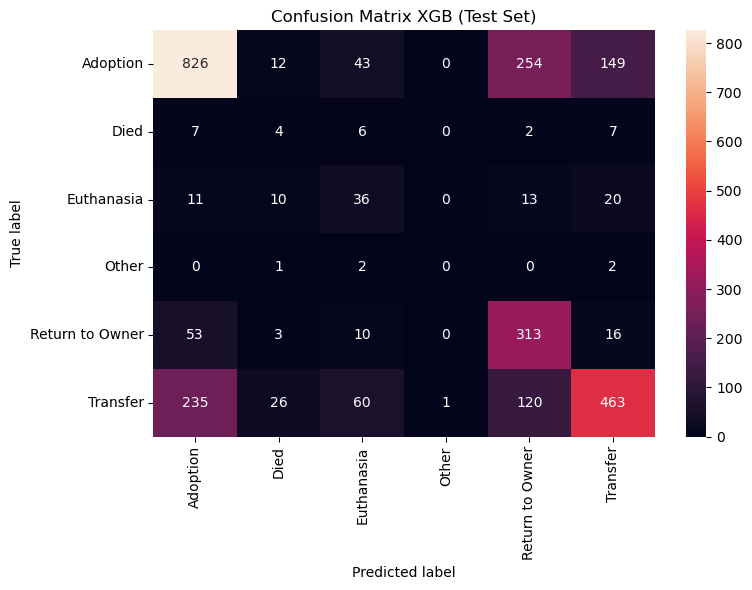

In [6]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Confusion Matrix XGB (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()

# Save figure
plt.savefig('../figures/confusion_matrix_XGB_test.png', dpi=300, bbox_inches='tight')

plt.show()


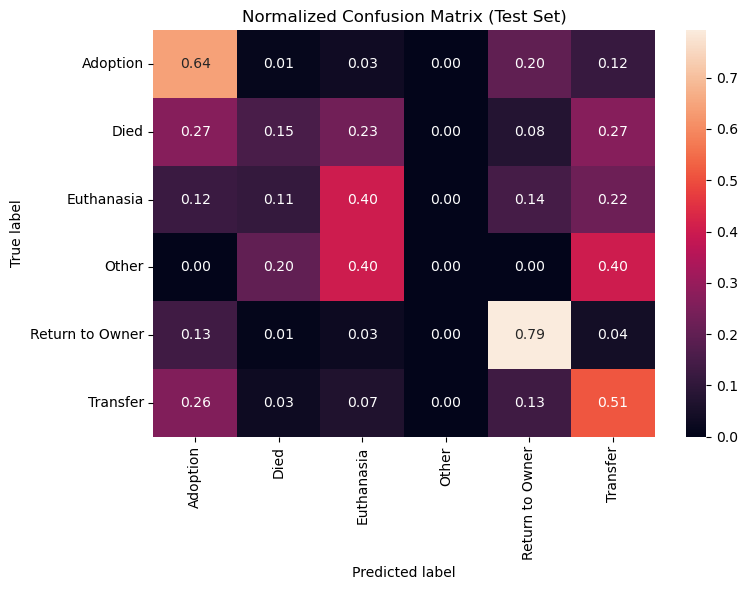

In [7]:
# Plot confusion matrix (Normalized)

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Normalized Confusion Matrix (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()

# Save figure
plt.savefig('../figures/confusion_matrix_normalized_XGB_test.png',
            dpi=300, bbox_inches='tight')

plt.show()

# 1) Permutation Feature Importance

In [8]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.metrics import fbeta_score

print("="*80)
print("PERMUTATION FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# ============================================================================
# LOAD SAVED RESULTS
# ============================================================================

print(f"\nLoading saved model results...")
with open('../results/final_model_XGB_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract what we need
model = results['model']
X_test_prep = results['X_test_prep']
y_test_encoded = results['y_test_encoded']
feature_names = results['feature_names']
FINAL_RANDOM_STATE = results['hyperparameters']['random_state']

print(f"✓ Loaded model and test data")
print(f"  Test samples: {len(X_test_prep)}")
print(f"  Features: {len(feature_names)}")

# ============================================================================
# DEFINE SCORING FUNCTION
# ============================================================================

def macro_f2_score(y_true, y_pred):
    """Calculate macro-averaged F2 score."""
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

# ============================================================================
# 1. PERMUTATION FEATURE IMPORTANCE
# ============================================================================

print(f"\n{'='*80}")
print("PERMUTATION FEATURE IMPORTANCE")
print(f"{'='*80}")

print(f"\nCalculating permutation importance on test set...")
print(f"  n_repeats: 10")
print(f"  scoring: macro F2")

perm_importance = permutation_importance(
    model,
    X_test_prep,
    y_test_encoded,
    n_repeats=10,
    random_state=FINAL_RANDOM_STATE,
    scoring=lambda est, X, y: macro_f2_score(y, est.predict(X)),
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std,
}).sort_values('importance_mean', ascending=False)

print(f"\n✓ Permutation importance complete!")

print(f"\nTop 20 features:")
print(f"{'Feature':<40s} {'Mean Δ F2':<12s} {'Std':<12s}")
print("-" * 65)
for idx, row in perm_importance_df.head(20).iterrows():
    print(f"{row['feature']:40s} {row['importance_mean']:+.5f}     ± {row['importance_std']:.5f}")

# ============================================================================
# PLOT PERMUTATION IMPORTANCE
# ============================================================================

print(f"\n{'='*80}")
print("CREATING PLOT")
print(f"{'='*80}")

# Plot top 20 features
top_20 = perm_importance_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))

y_pos = np.arange(len(top_20))
ax.barh(y_pos, top_20['importance_mean'], xerr=top_20['importance_std'],
        color='steelblue', alpha=0.8, capsize=3)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Decrease in Macro F2 Score', fontweight='bold', fontsize=11)
ax.set_title('Top 20 Features by Permutation Importance', fontweight='bold', fontsize=13)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/permutation_importance_plot.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ Saved: permutation_importance_plot.png")

PERMUTATION FEATURE IMPORTANCE ANALYSIS

Loading saved model results...
✓ Loaded model and test data
  Test samples: 2705
  Features: 979

PERMUTATION FEATURE IMPORTANCE

Calculating permutation importance on test set...
  n_repeats: 10
  scoring: macro F2

✓ Permutation importance complete!

Top 20 features:
Feature                                  Mean Δ F2    Std         
-----------------------------------------------------------------
age_days_intake                          +0.05853     ± 0.00953
HasName_0                                +0.04890     ± 0.00278
intake_condition_Normal                  +0.03313     ± 0.00466
intake_type_Owner Surrender              +0.02753     ± 0.00569
intake_type_Public Assist                +0.00748     ± 0.00119
intactness_intact                        +0.00719     ± 0.00356
intake_condition_Injured                 +0.00714     ± 0.00217
intactness_not_intact                    +0.00526     ± 0.00192
intake_type_Euthanasia Request           +0.

# 2) XgBoost in-built global feature importance metrics

XGBOOST BUILT-IN FEATURE IMPORTANCE (ALL 5 TYPES)

Loading saved model results...
✓ Loaded model
  Features: 979

XGBOOST BUILT-IN IMPORTANCES (ALL 5 TYPES)

Using importance type: 'weight'
Top 20 features by XGBoost weight:
Feature                                  Weight      
-------------------------------------------------------
age_days_intake                          8083.00000
intake_hour_sin                          3862.00000
intake_month_num_sin                     3340.00000
intake_month_num_cos                     3224.00000
intake_weekday_num_sin                   3109.00000
intake_hour_cos                          2810.00000
intake_weekday_num_cos                   1944.00000
HasName_0                                1551.00000
intake_condition_Normal                  1536.00000
color_Black/White                        1295.00000
breed_Domestic Shorthair                 996.00000
animal_type_Cat                          869.00000
intake_type_Owner Surrender              85

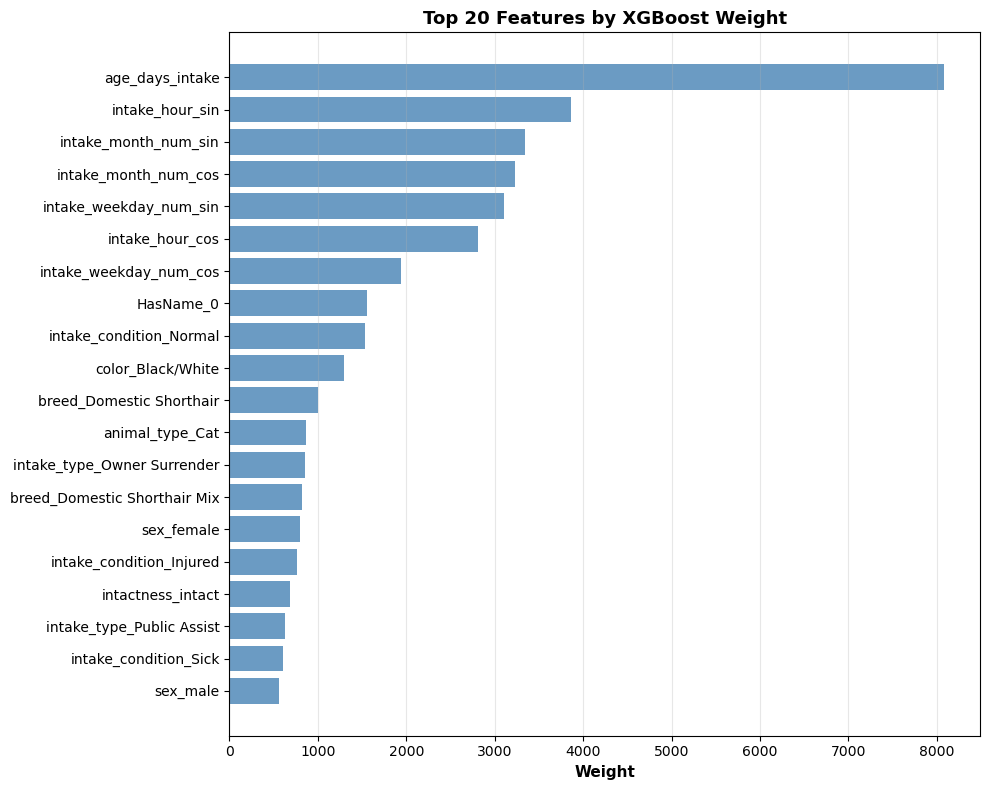

✓ Saved: ../figures/xgboost_importance_weight.png


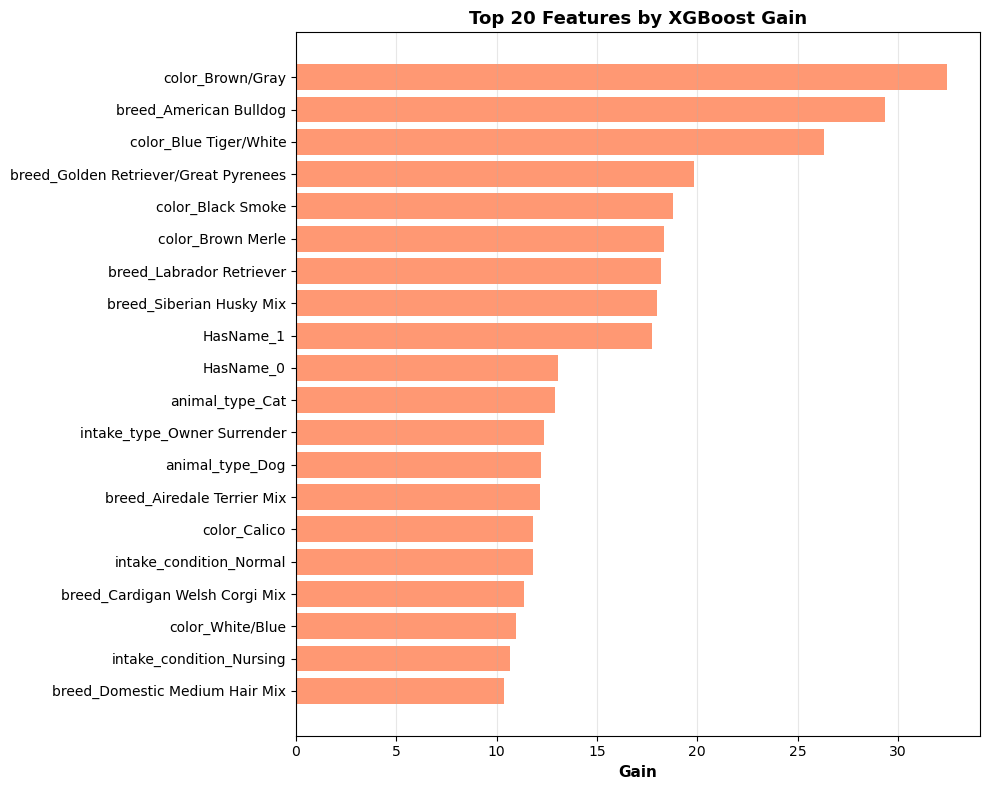

✓ Saved: ../figures/xgboost_importance_gain.png


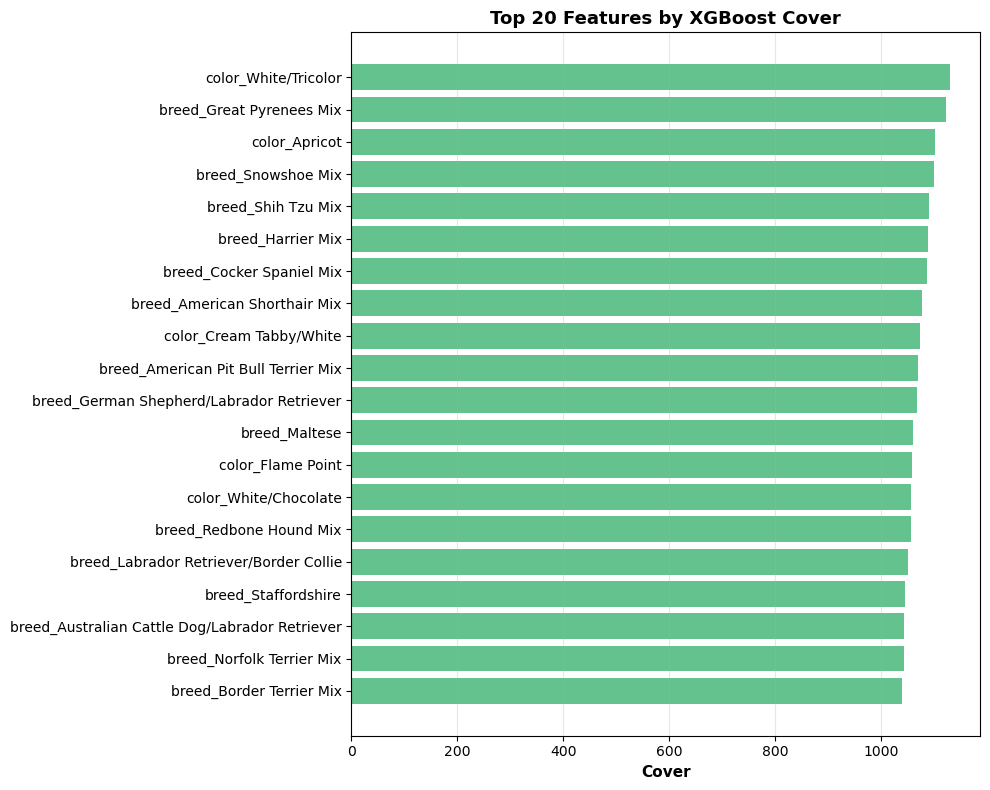

✓ Saved: ../figures/xgboost_importance_cover.png


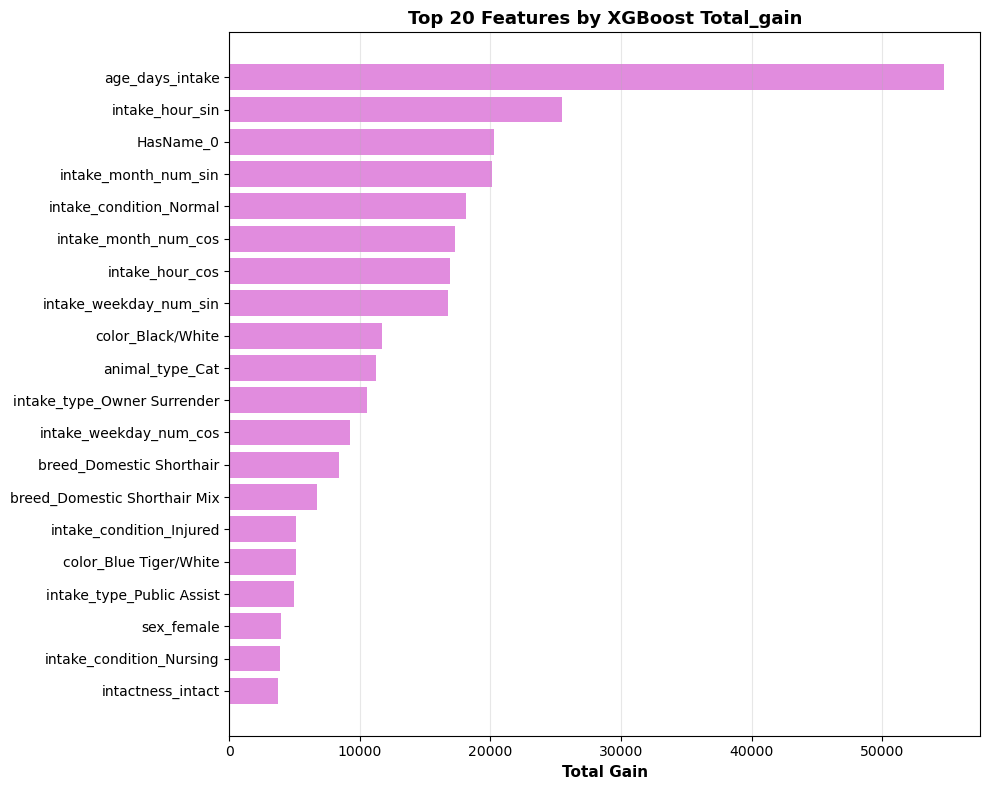

✓ Saved: ../figures/xgboost_importance_total_gain.png


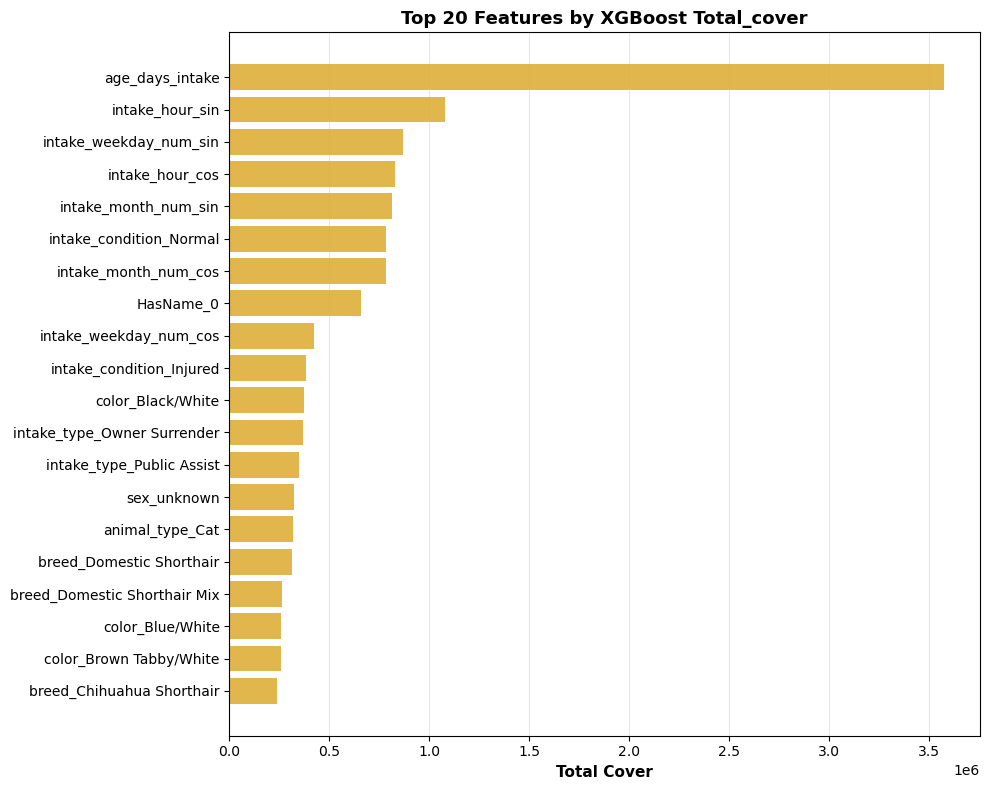

✓ Saved: ../figures/xgboost_importance_total_cover.png


In [11]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("XGBOOST BUILT-IN FEATURE IMPORTANCE (ALL 5 TYPES)")
print("="*80)

# ============================================================================
# LOAD SAVED RESULTS
# ============================================================================

print(f"\nLoading saved model results...")
with open('../results/final_model_XGB_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract what we need
model = results['model']
feature_names = results['feature_names']

print(f"✓ Loaded model")
print(f"  Features: {len(feature_names)}")

# ============================================================================
# 2. XGBOOST BUILT-IN IMPORTANCES (ALL 5 TYPES)
# ============================================================================

print(f"\n{'='*80}")
print("XGBOOST BUILT-IN IMPORTANCES (ALL 5 TYPES)")
print(f"{'='*80}")

importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
booster = model.get_booster()

def get_importance_df(booster, feature_names, importance_type):
    """
    Build a DataFrame with importances for all features for a given type.
    XGBoost keys are 'f0', 'f1', ... in the order of the input features.
    """
    score_dict = booster.get_score(importance_type=importance_type)
    importances = []
    for i in range(len(feature_names)):
        key = f"f{i}"
        importances.append(score_dict.get(key, 0.0))  # 0 if feature never used
    df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
    }).sort_values('importance', ascending=False)
    return df

xgb_importance_all = {}

for imp_type in importance_types:
    imp_df = get_importance_df(booster, feature_names, imp_type)
    xgb_importance_all[imp_type] = imp_df
    
    print(f"\nUsing importance type: '{imp_type}'")
    print(f"Top 20 features by XGBoost {imp_type}:")
    print(f"{'Feature':<40s} {imp_type.capitalize():<12s}")
    print("-" * 55)
    for _, row in imp_df.head(20).iterrows():
        print(f"{row['feature']:40s} {row['importance']:.5f}")

# ============================================================================
# CREATE SEPARATE PLOTS FOR EACH IMPORTANCE TYPE
# ============================================================================

print(f"\n{'='*80}")
print("CREATING PLOTS")
print(f"{'='*80}")

# Define nice labels and colors for each type
plot_config = {
    'weight':      {'label': 'Weight',      'color': 'steelblue'},
    'gain':        {'label': 'Gain',        'color': 'coral'},
    'cover':       {'label': 'Cover',       'color': 'mediumseagreen'},
    'total_gain':  {'label': 'Total Gain',  'color': 'orchid'},
    'total_cover': {'label': 'Total Cover', 'color': 'goldenrod'}
}

for imp_type in importance_types:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get top 20 features for this type
    top_20 = xgb_importance_all[imp_type].head(20)
    
    y_pos = np.arange(len(top_20))
    ax.barh(
        y_pos,
        top_20['importance'],
        color=plot_config[imp_type]['color'],
        alpha=0.8
    )
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_20['feature'])
    ax.invert_yaxis()
    ax.set_xlabel(plot_config[imp_type]['label'], fontweight='bold', fontsize=11)
    ax.set_title(f'Top 20 Features by XGBoost {imp_type.capitalize()}',
                 fontweight='bold', fontsize=13)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    filename = f'../figures/xgboost_importance_{imp_type}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"✓ Saved: {filename}")


# 3) Global SHAP

GLOBAL SHAP VALUES ANALYSIS

Loading saved model results...
✓ Loaded model and test data
  Test samples: 2705
  Features: 979
  Classes: 6 - ['Adoption', 'Died', 'Euthanasia', 'Other', 'Return to Owner', 'Transfer']

GLOBAL SHAP VALUES

Calculating SHAP values on test set...
✓ SHAP values calculated!
  Shape: (2705, 979, 6)
  (samples × features × classes)

Top 20 features by sum of |SHAP| (summed over samples & classes):
Feature                                  Sum |SHAP|  
-------------------------------------------------------
age_days_intake                          10592.78223
intake_condition_Normal                  6050.58105
HasName_0                                5846.95166
intake_weekday_num_sin                   5291.67725
intake_hour_sin                          5124.31641
intake_month_num_sin                     5052.17822
intake_month_num_cos                     4442.88916
animal_type_Cat                          3875.09497
intake_type_Owner Surrender              3249.8

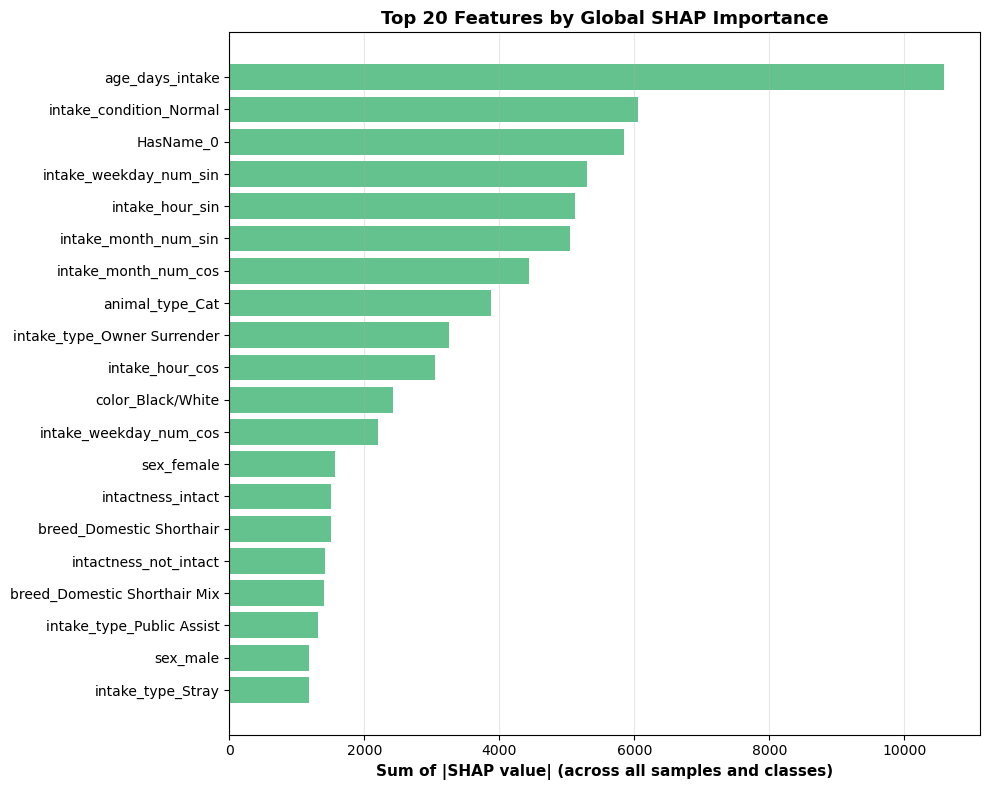

✓ Saved: global_shap_importance.png


In [14]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap

print("="*80)
print("GLOBAL SHAP VALUES ANALYSIS")
print("="*80)

# ============================================================================
# LOAD SAVED RESULTS
# ============================================================================

print(f"\nLoading saved model results...")
with open('../results/final_model_XGB_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Extract what we need
model = results['model']
X_test_prep = results['X_test_prep']
y_test_encoded = results['y_test_encoded']
feature_names = results['feature_names']
label_encoder = results['label_encoder']

print(f"✓ Loaded model and test data")
print(f"  Test samples: {len(X_test_prep)}")
print(f"  Features: {len(feature_names)}")
print(f"  Classes: {len(label_encoder.classes_)} - {list(label_encoder.classes_)}")

# ============================================================================
# 3. GLOBAL SHAP VALUES
# ============================================================================

print(f"\n{'='*80}")
print("GLOBAL SHAP VALUES")
print(f"{'='*80}")

print(f"\nCalculating SHAP values on test set...")

# Create SHAP explainer (optimized for tree models)
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for test set
shap_values = explainer(X_test_prep)

print(f"✓ SHAP values calculated!")
print(f"  Shape: {shap_values.values.shape}")
print(f"  (samples × features × classes)")

# ============================================================================
# GLOBAL IMPORTANCE: SUM of |SHAP| across samples and ALL classes
# ============================================================================

# SHAP values can be negative, and we take absolute value before summing

# shap_values.values shape: (n_samples, n_features, n_classes)
shap_summary = np.abs(shap_values.values).sum(axis=(0, 2))

# Build DataFrame
global_shap_df = pd.DataFrame({
    'feature': feature_names,
    'sum_abs_shap': shap_summary  
}).sort_values('sum_abs_shap', ascending=False)

TOP_N = 20

print(f"\nTop {TOP_N} features by sum of |SHAP| (summed over samples & classes):")
print(f"{'Feature':<40s} {'Sum |SHAP|':<12s}")
print("-" * 55)
for _, row in global_shap_df.head(TOP_N).iterrows():
    print(f"{row['feature']:40s} {row['sum_abs_shap']:.5f}")

# ============================================================================
# PLOT GLOBAL SHAP IMPORTANCE
# ============================================================================

print(f"\n{'='*80}")
print("CREATING PLOT")
print(f"{'='*80}")

# Get top 20 features
top_20 = global_shap_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))

y_pos = np.arange(len(top_20))
ax.barh(y_pos, top_20['sum_abs_shap'], color='mediumseagreen', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()
# CORRECTED LABEL: Sum, not mean!
ax.set_xlabel('Sum of |SHAP value| (across all samples and classes)', 
              fontweight='bold', fontsize=11)
ax.set_title('Top 20 Features by Global SHAP Importance', 
             fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/global_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"✓ Saved: global_shap_importance.png")